<a href="https://colab.research.google.com/github/yaobviously/sym-cargo/blob/main/sym_cargo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly-express --quiet
!pip install vincenty --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vincenty import vincenty
from sklearn.neighbors import NearestNeighbors
import plotly_express as px

In [4]:
port_file = '/content/drive/MyDrive/Ports/ports.csv'
tracking_file = '/content/drive/MyDrive/Ports/tracking.csv'

In [83]:
def wrangle():
  df1 = pd.read_csv(port_file)

  # converting lat and long to radians to compute haversine distance
  df1['lat_rad'] = np.radians(df1['lat'])
  df1['long_rad'] = np.radians(df1['long'])
  
  # rounding lat and long in port df
  df1['lat'] = df1['lat'].round(1)
  df1['long'] = df1['long'].round(1)

  df2 = pd.read_csv(tracking_file, parse_dates=['datetime'])
  df2 = df2.drop_duplicates()
  df2 = df2.sort_values(['vessel', 'datetime'])
  
  # converting lat and long to radians to compute haversine distance  
  df2['lat_rad'] = np.radians(df2['lat'])
  df2['long_rad'] = np.radians(df2['long'])

  # adding lat/long column and lat/long 1 back to later compute delta
  df2['lat_long'] = [[x,y] for x, y in zip(df2['lat'], df2['long'])]
  df2['lat_long_1back'] = df2.groupby('vessel')['lat_long'].transform(lambda x: x.shift())   
  
  # months and days
  df2['time_delta'] = df2.groupby('vessel')['datetime'].transform(lambda x: x.diff(1))
  df2['delta_hours'] = df2.groupby('vessel')['time_delta'].transform(lambda x: [(n.seconds/3600) + (n.days *24) for n in x])
  df2 = df2.drop(columns=['time_delta'])

  df2 = df2.reset_index(drop=True)

  return df1, df2

In [84]:
df1, df2 = wrangle()

In [119]:
# creating a dictionary of ports with their lat and longs - will be used to
# repeatedly to explore data and assign values

ports = {port:(lat, long) for port, lat, long in zip(df1['port'], df1['lat'], df1['long'])}

# a dictionary to retrieve the port id from the index
idx_ports = {idx:port for idx, port in zip(df1.index, df1.port)}

In [8]:
# training a nearest neighbor model to  find the closest port when the 
# conditions indicating an extended stop have occurred. the metric is haversine
# in order to compute the 'great circle' distance. so i don't forget, the model
# returns the *index* of the port, not the port's identifying label

ports_train = df1[['lat_rad', 'long_rad']]

neigh_ports = NearestNeighbors(n_neighbors=3, algorithm='ball_tree', metric='haversine')
neigh_ports.fit(ports_train)

dist, n = neigh_ports.kneighbors(np.array([0.677565, 0.469731]).reshape(1,-1))

print(dist[0] * 6370)
print([idx_ports[n] for n in n[0]])

[  3.30931026  46.44757565 255.13837716]
[82, 113, 44]


In [9]:
# functions to quickly inspect dataframe to figure out what's up

# def get_dates(vessel=111, start='2019-01-01', end='2019-12-25'):

#   df = df2[(df2.datetime >= start) & (df2.datetime <=end)]
#   df = df[df['vessel'] == vessel]
  
#   return df

# def where_zero(vessel = 75):
  
#   df_ = df2[(df2['vessel'] == vessel) & (df2['speed'] <= 0.5)]
  
#   return df_

In [10]:
def nearest_port(df):
  """
  returns the port identifier of the nearest port using the nearest neighbors
  model 
  """

  data = np.array([df['lat_rad'], df['long_rad']]).reshape(1, -1)
  dist, pred = neigh_ports.radius_neighbors(data, radius=0.008, sort_results = True) 

  if len(dist[0]) == 0:
    return -1
  
  else:
    return idx_ports[pred[0][0]]

In [11]:
def nearest_distance(df):
  """
  returns the distance of the nearest port in the dataset
  """
  
  data = np.array([df['lat_rad'], df['long_rad']]).reshape(1, -1)
  dist, pred = neigh_ports.radius_neighbors(data, radius=0.0085, sort_results = True) 

  if len(dist[0]) == 0:
    return -1
  
  else:
    return dist[0][0]


In [12]:
def vincent_distance(row):
  """ 
  returns the vincenty distance for contiguous rows - defunct
  """
  if row['vessel'] != row['vessel_1back']:
    return -99

  loc1 = row['lat_long']
  loc2 = row['lat_long_1back']

  try:
    distance = vincenty(loc1, loc2)
    return distance
  except:
    return -99

In [75]:
def vincenty_port(row):
  """
  a function that computes the vincenty distance between the assigned port
  and the latitude and longitude of the location data. 
  """
  port = row['port_coords']
  loc = row['lat_long']
  return vincenty(port, loc)

In [ ]:
# calculating the minimum and maximum vincenty distances from ports and 
# storing the values in a dictionary. it may prove useful when distinguishing
# between 'in port' and 'waiting around to enter the port'

# port_dist = {}

# for port in port_ds.keys():
#   max_vincenty = port_ds[port]['vdist_port'].max()
#   min_vincenty = port_ds[port]['vdist_port'].min()
#   port_dist[port] = [max_vincenty, min_vincenty]

In [ ]:
# def hanging_around(row):

#   key = int(row['pred_port'])

#   if key < 0:
#     return 0

#   from_min = row['vindist_pred_port'] - port_dist[key][1]

#   try:
#     if from_min >= 20:
#       return 1
#     else:
#       return 0

#   except:
#     return -1

In [ ]:
# # creating a dictionary of dataframes for each port

# port_ds = {}

# for port in df2.pred_port.unique():
#   df_ = df2[df2['pred_port'] == port]
#   port_ds[port] = df_.set_index('datetime')

# del port_ds[-1]

# for n in port_ds.keys():
#   port_ds[n][f'{n}_coord'] = [ports[n]] * len(port_ds[n])

# for n in port_ds.keys():
#   port_ds[n]['vdist_port'] = [vincenty(x, y) for x, y in zip(port_ds[n][f'{n}_coord'], port_ds[n]['lat_long'])]


In [128]:
def assign_ports(df):
  """
  a function that prepares a dataframe for predictions

  Parameters:
  ----------
        df: pandas dataframe
  
  Returns:
  -------
        df: processed pandas dataframe

  """

  # resampling the data to standardize time intervals
  df = df.resample('4H').mean().ffill()
  df['lat_rad'] = df['lat_rad'].resample('4H').median().ffill()
  df['long_rad'] = df['long_rad'].resample('4H').median().ffill()
  
  # applying a mask to limit the rows the predict function is applied to
  mask = df['speed'] <= 3
  df_temp = df[mask]

  df['pred_port'] = 0
  df.loc[mask, 'pred_port'] = df_temp.apply(nearest_port, axis=1)  
  df['port_coords'] = [list(ports[k]) if k in ports else -99 for k in df['pred_port']]
  df['lat_long'] = [[x,y] for x, y in zip(df['lat'], df['long'])]

  # applying a mask to limit the rows vincenty func is applied to
  vin_mask = (df['pred_port'] > 0)
  vin_temp = df[vin_mask]
  
  df['port_dist'] = 0
  df.loc[vin_mask, 'port_dist'] = vin_temp.apply(vincenty_port, axis=1)

  # recasting vessel and pred_port columns as integers
  df[['vessel', 'pred_port']] = df[['vessel', 'pred_port']].astype(int)

  return df

In [17]:
# creating a dictionary of vessel dataframes with a datetime index

vessel_dfs = {}

for vessel in df2.vessel.unique():
  df_ = df2[df2['vessel'] == vessel]
  vessel_dfs[vessel] = df_.set_index('datetime')

# assigning ports to each dataframe

processed_dfs = {f'port_{key}':assign_ports(vessel_dfs[key]) for key in vessel_dfs.keys()}

In [123]:
def get_voyages(df):
  """
  a function to convert the port sequences in each dataframe into voyages
  with the proper formatting

  Parameters:
  ----------
      df: pandas DataFrame
  
  Returns:
  -------
      df: processed pandas DataFrame
      
  """
  # filtering out columns without an assigned port
  nz = df[df['pred_port'] > 0].reset_index()
  
  vessel = nz['vessel'][0]
  dt = nz['datetime']
  pred = nz['pred_port']

  records = []

  for i in range(len(dt)-1):
    if pred[i] != pred[i+1]:
      start_port = pred[i]
      end_port = pred[i+1]
      begin_date = dt[i]
      end_date = dt[i+1]
      records.append([vessel, begin_date, end_date, start_port, end_port])

  df = pd.DataFrame.from_records(records, columns = ['vessel', 'begin_date', 'end_date', 'begin_port_id', 'end_port_id'])
  
  return df

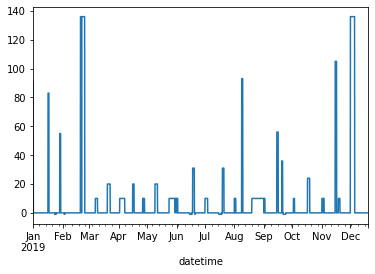

In [132]:
processed_dfs['port_56']['pred_port'].plot()

In [ ]:
voyages_dict = pd.concat([get_voyages(vessel_dfs[n]) for n in vessel_dfs.keys()])

In [ ]:
df3 = voyages_dict
df3['len_voyage'] = df3['end_date'] - df3['begin_date']

In [ ]:
# simple mapping tool to inspect routes

fig = px.scatter_geo(f,lat='lat',lon='long', hover_name="datetime")

fig.update_layout(title = 'Vessel Locations', title_x=0.5)
fig.show()

In [ ]:
# the dataframes to submit

voyages = pd.DataFrame(columns= ['vessel', 'begin_date', 'end_date', 'begin_port_id', 'end_port_id'])
predict = pd.DataFrame(columns= ['vessel', 'begin_port_id', 'end_port_id', 'voyage'])